In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T


In [2]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        # Load labels
        labels = []
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                labels.append([class_id, x_center, y_center, width, height])
        
        labels = torch.tensor(labels)
        return image, labels

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
def custom_collate_fn(batch):
    images = []
    targets = []

    for b in batch:
        images.append(b[0])
        targets.append(b[1])

    images = torch.stack(images, dim=0)
    return images, targets

In [5]:
train_dataset = CustomDataset(img_dir='datasets/train/images', label_dir='datasets/train/labels', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)

val_dataset = CustomDataset(img_dir='datasets/valid/images', label_dir='datasets/valid/labels', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

test_dataset = CustomDataset(img_dir='datasets/test/images', label_dir='datasets/test/labels', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)


In [37]:
class ResNet50ObjectDetector(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50ObjectDetector, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.num_classes = num_classes
        
        self.conv = nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 26 * (num_classes + 4))
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # Reshape output to [batch_size, num_classes, 5] (class, x, y, w, h)
        return x.view(x.size(0), -1, self.num_classes + 4)

model = ResNet50ObjectDetector(num_classes=4)  # Assuming 4 classes: players, referee, goalkeepers, ball


In [38]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet50ObjectDetector(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [31]:
def custom_loss_function(outputs, targets):
    loss = 0
    for output, target in zip(outputs, targets):
        num_targets = target.size(0)
        num_predictions = output.size(0)

        # Move target to the same device as the output
        target = target.to(output.device)

        if num_targets > num_predictions:
            target = target[:num_predictions]
        elif num_predictions > num_targets:
            padding = torch.zeros((num_predictions - num_targets, 5), device=output.device)
            target = torch.cat([target, padding], dim=0)

        loss += criterion(output, target)
    
    return loss / len(outputs)


In [32]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = images.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = custom_loss_function(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(dataloader)


In [39]:
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss}')


RuntimeError: The size of tensor a (8) must match the size of tensor b (5) at non-singleton dimension 1

In [43]:
torch.save(model.state_dict(), 'object_detector.pth')

In [11]:
model.load_state_dict(torch.load('object_detector.pth'))

<All keys matched successfully>

In [12]:
# Function to load and preprocess the image
def load_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((224, 224)),  # Ensure this matches the transform used during training
        T.ToTensor(),
    ])
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image

In [17]:
# Function to load true bounding boxes from the label file
def get_true_boxes(label_path, original_shape, resized_shape):
    with open(label_path, 'r') as f:
        boxes = []
        for line in f.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center *= resized_shape[1]
            y_center *= resized_shape[0]
            width *= resized_shape[1]
            height *= resized_shape[0]

            # Convert to original image dimensions
            x_center = x_center * (original_shape[1] / resized_shape[1])
            y_center = y_center * (original_shape[0] / resized_shape[0])
            width = width * (original_shape[1] / resized_shape[1])
            height = height * (original_shape[0] / resized_shape[0])

            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            boxes.append([x1, y1, x2, y2, class_id])
    return boxes

In [20]:
# Function to rescale predicted boxes to the original image size
def rescale_pred_boxes(pred_boxes, original_shape):
    pred_boxes[:, 1] *= original_shape[1]
    pred_boxes[:, 2] *= original_shape[0]
    pred_boxes[:, 3] *= original_shape[1]
    pred_boxes[:, 4] *= original_shape[0]
    return pred_boxes

In [15]:
# Function to plot the image with true and predicted boxes
def plot_boxes(image_path, true_boxes, pred_boxes, class_names):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    ax = plt.gca()

    # Plot true boxes (green)
    for box in true_boxes:
        x1, y1, x2, y2, class_id = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='green', linewidth=2)
        ax.add_patch(rect)
        plt.text(x1, y1, f'True: {class_names[int(class_id)]}', color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    # Plot predicted boxes (red)
    for box in pred_boxes:
        x1, y1, x2, y2, class_id = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        plt.text(x1, y1, f'Pred: {class_names[int(class_id)]}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

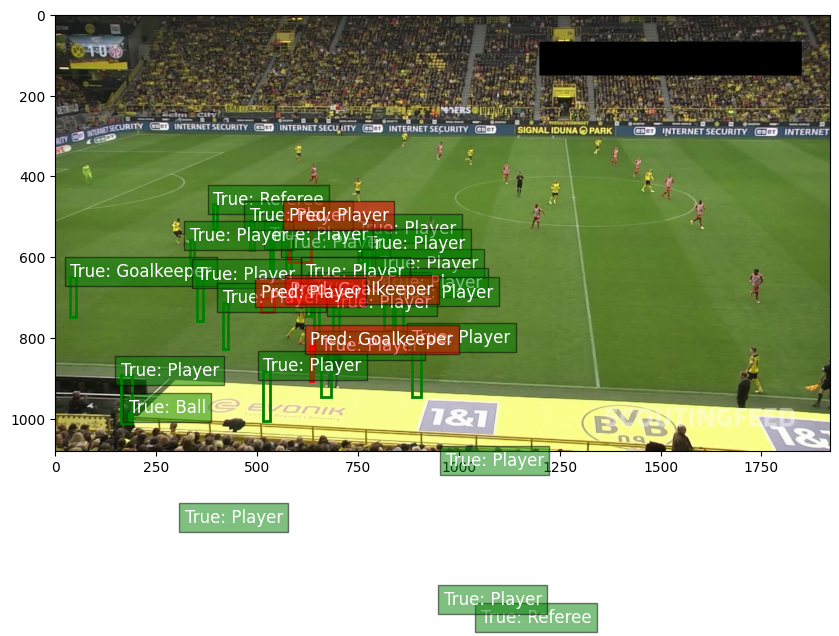

In [21]:

label_path = './datasets/test/labels/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.txt'
image_path = './datasets/test/images/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.jpg'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image = Image.open(image_path).convert("RGB")
original_shape = image.size  # (Width, Height)
resized_image = load_image(image_path, device)
resized_shape = (224, 224)  # The shape used during training

true_boxes = get_true_boxes(label_path, original_shape, resized_shape)

# Run the model to get predictions
model.eval()
with torch.no_grad():
    outputs = model(resized_image)
outputs = outputs[0].cpu()  # Move to CPU and remove batch dimension

# Rescale predicted boxes to original image dimensions
pred_boxes = rescale_pred_boxes(outputs, original_shape)

# Convert center coordinates to top-left and bottom-right for predicted boxes
pred_boxes = [
    [
        box[1] - box[3] / 2, box[2] - box[4] / 2,  # x1, y1
        box[1] + box[3] / 2, box[2] + box[4] / 2,  # x2, y2
        box[0]  # class_id
    ]
    for box in pred_boxes
]

# Define your class names
class_names = ['Ball', 'Goalkeeper', 'Player', 'Referee']

# Plot the image with true and predicted boxes
plot_boxes(image_path, true_boxes, pred_boxes, class_names)